In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import numpy as np
import json
import os

In [74]:
changeConfig = input("Хотите ли вы изменить файл кофигурации? (Y/n): ")

if (changeConfig == 'Y') or (changeConfig == 'y'):

    with open('config.json', 'r') as file:
        data = json.load(file)

    data['UserParameters']['PathInitialAge'] = input("Укажите путь к файлу с первоначальным возрастным составом населения: ") or "D:\proga\sem3\lab6\InitialAge.csv"
    data['UserParameters']['PathDeathRules'] = input("Укажите путь к файлу с таблицей смертности: ") or "D:\proga\sem3\lab6\DeathRules.csv"
    data['UserParameters']['StartYear'] = int(input("Введите год начала моделирования (по умолчанию 1970): ") or 1970)
    data['UserParameters']['EndYear'] = int(input("Введите год окончания моделирования (по умолчанию 2021): ") or 2021)
    data['UserParameters']['OriginalPopulation'] = input("Введите начальную общую численность населения (по умолчанию 130 млн.): ") or 130000000

    print(data)
    
    with open('config.json', 'w') as file:
        json.dump(data, file, indent=4)
else:
    with open('config.json', 'r') as file:
        data = json.load(file)

start_year = int(data['UserParameters']['StartYear'])
end_year = int(data['UserParameters']['EndYear'])

In [75]:
exe = subprocess.run(['exe\Demographic.Exec.exe', "D:\proga\sem3\lab6\config.json"], capture_output=True, text=True)

print(exe)

output = exe.stdout
lines = output.splitlines()
path = lines[-1]

print(path)

CompletedProcess(args=['exe\\Demographic.Exec.exe', 'D:\\proga\\sem3\\lab6\\config.json'], returncode=0, stdout='145990\nPopulation: 211480\nAlive: 211480\nDead: 233507\nCSV-д\xa0©« б®§¤\xa0\xad: \nPopulation.csv\n', stderr='')
Population.csv


In [76]:
path = "D:\proga\sem3\lab6\Masha\Demographic1\populationInfo.csv"
data = pd.read_csv(path)

data.head()

header = pd.read_csv(path, nrows=0).columns.tolist()
error = False
error_message = ""

for col in header:
    if 'Ошибка' in col:
        error = True
        error_message = col
        os.remove(path)
        break

In [77]:
def analysis_file():
    years = range(start_year - 100, end_year + 1)
    print(years)
    population_over_years = pd.DataFrame(index=years)

    # Инициализация колонок для общего населения, мужского и женского
    population_over_years['Total'] = 0
    population_over_years['Male'] = 0
    population_over_years['Female'] = 0
    population_over_years['Births'] = 0  # Количество рождений
    population_over_years['Deaths'] = 0  # Количество смертей

    # Преобразование данных для векторизации
    data['Alive'] = (data['birth_year'] <= end_year) & ((data['death_year'] > end_year) | pd.isna(data['death_year']))

    # Подсчет общего населения по годам с использованием векторизации
    for year in years:
        # Фильтруем людей, которые были живы в данный год
        alive_mask = (data['birth_year'] <= year) & ((data['death_year'] > year) | pd.isna(data['death_year']))
        
        population_over_years.loc[year, 'Total'] = alive_mask.sum()
        population_over_years.loc[year, 'Male'] = (alive_mask & (data['gender'] == 'Male')).sum()
        population_over_years.loc[year, 'Female'] = (alive_mask & (data['gender'] == 'Female')).sum()

        population_over_years.loc[year, 'Births'] = ((data['birth_year'] == year)).sum()
        population_over_years.loc[year, 'Deaths'] = ((data['death_year'] == year)).sum()

    return population_over_years[(population_over_years['Births'] > 0) | (population_over_years['Deaths'] > 0)]

In [78]:
def draw_total_population(filtered_population_data):
    plt.figure(figsize=(18, 6))
    print(filtered_population_data)

    plt.plot(filtered_population_data.index, filtered_population_data['Total'], label='Общее население', marker='o')
    plt.plot(filtered_population_data.index, filtered_population_data['Male'], label='Мужское население', marker='o', color='blue')
    plt.plot(filtered_population_data.index, filtered_population_data['Female'], label='Женское население', marker='o', color='red')

    plt.axvline(x=start_year, color='red', linestyle='--', label='Начало периода')
    plt.axvline(x=end_year, color='red', linestyle='--', label='Конец периода')
    
    plt.title('Изменение общего населения по годам')
    plt.xlabel('Год')
    plt.ylabel('Количество людей (в тыс)')
    plt.legend()
    plt.grid()
    plt.show()

In [79]:
def draw_birthAndDeath(filtered_population_data):
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_population_data.index, filtered_population_data['Births'], label='Рождаемость', marker='o', color='green')
    plt.plot(filtered_population_data.index, filtered_population_data['Deaths'], label='Смертность', marker='o', color='orange')

    #plt.axvline(x=start_year, color='red', linestyle='--', label='Начало периода')
    #plt.axvline(x=end_year, color='red', linestyle='--', label='Конец периода')

    plt.title('Рождаемость и смертность по годам')
    plt.xlabel('Год')
    plt.ylabel('Количество (в тыс.)')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

In [80]:
def draw_bins():
    age_bins = ['0 - 18', '19 - 44', '45 - 65', '66 - 100']
    
    alive_condition = (data['death_year'].isnull()) | (data['death_year'] > end_year)
    # Подсчет возрастного состава для мужчин
    male_counts = [
       ((data['birth_year'] > end_year - 18) & 
        (data['birth_year'] <= end_year) & 
        (data['gender'] == 'Male') &alive_condition).sum(),
       ((data['birth_year'] > end_year - 44) & 
        (data['birth_year'] <= end_year - 19) & 
        (data['gender'] == 'Male') & alive_condition).sum(),
       ((data['birth_year'] > end_year - 65) & 
        (data['birth_year'] <= end_year - 45) & 
        (data['gender'] == 'Male') & alive_condition).sum(),
       ((data['birth_year'] <= end_year - 66) & 
        (data['gender'] == 'Male') & alive_condition).sum()
   ]
    # Подсчет возрастного состава для женщин
    female_counts = [
       ((data['birth_year'] > end_year - 18 - 18) & 
        (data['birth_year'] <= end_year - 18) & 
        (data['gender'] == 'Female') & 
        alive_condition).sum(),
       ((data['birth_year'] > end_year - 44) & 
        (data['birth_year'] <= end_year - 19) & 
        (data['gender'] == 'Female') & alive_condition).sum(),
       ((data['birth_year'] > end_year - 65) & 
        (data['birth_year'] <= end_year - 45) & 
        (data['gender'] == 'Female') & alive_condition).sum(),
       ((data['birth_year'] <= end_year - 66) & 
        (data['gender'] == 'Female') & alive_condition).sum()
   ]
   


    # Настройка ширины столбцов
    width = 0.35  # ширина столбца

    # Позиции для мужчин и женщин
    x = range(len(age_bins))
    
    # Построение графика
    plt.bar(x, male_counts, width, label='Мужчины', color='blue', align='center')
    plt.bar([p + width for p in x], female_counts, width, label='Женщины', color='pink', align='center')

    # Настройка графика
    plt.title('Возрастной состав населения по полу')
    plt.xlabel('Возрастные категории')
    plt.ylabel('Количество (в тыс.)')
    plt.xticks([p + width / 2 for p in x], age_bins)
    plt.legend()

    plt.tight_layout()
    plt.grid()
    plt.show()

range(1870, 2022)


       Total    Male  Female  Births  Deaths
1879     668     334     334     668       0
1889    1632     816     816     964       0
1894    3403    1702    1701    1771       0
1899    6226    3114    3112    2823       0
1904   10258    5130    5128    4032       0
...      ...     ...     ...     ...     ...
2017  218160   97621  120539    9484    4829
2018  222705   99683  123022    9510    4965
2019  227444  101796  125648    9766    5027
2020  232331  104072  128259    9940    5053
2021  237049  106227  130822   10035    5317

[70 rows x 5 columns]


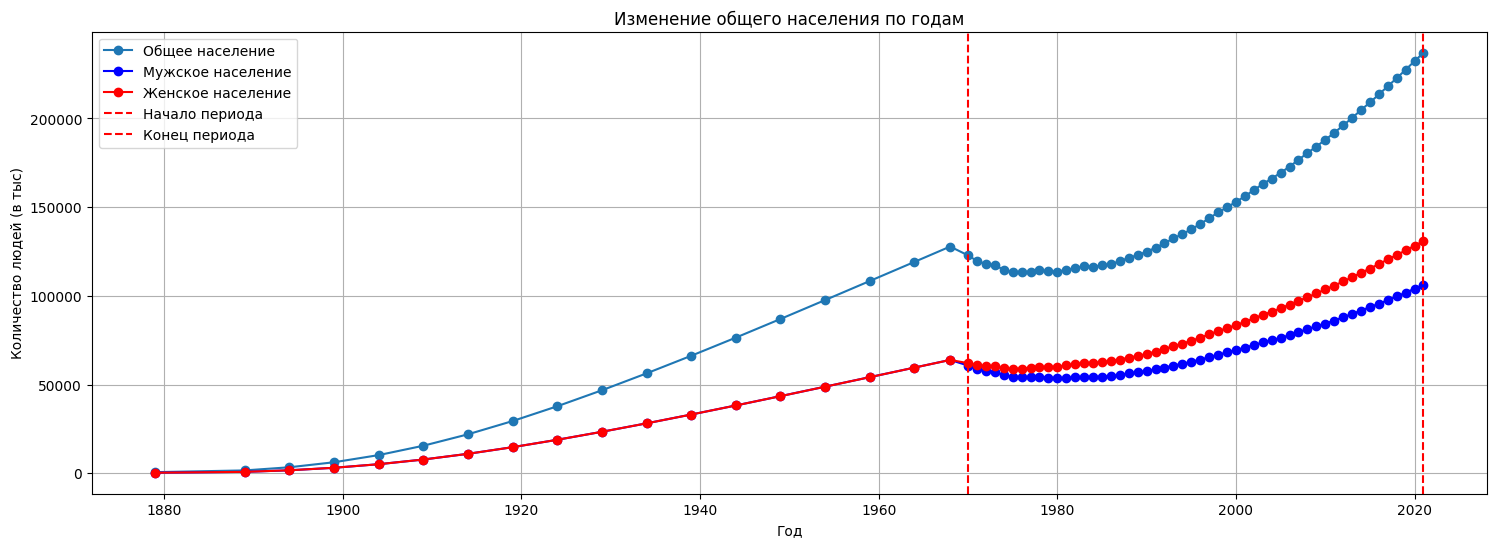

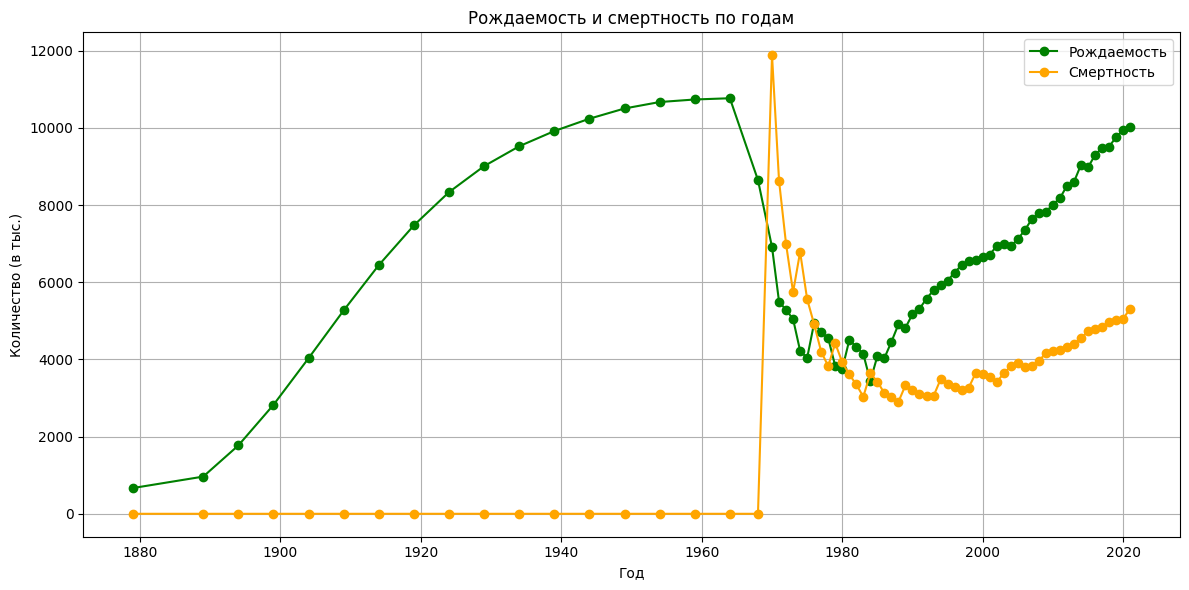

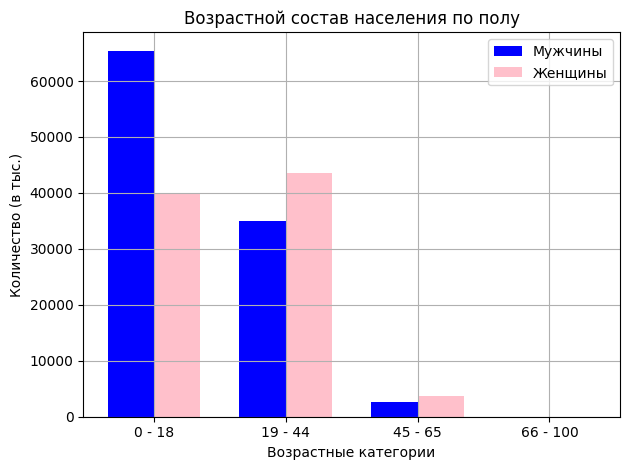

In [81]:
if error == True:
    print(error_message)
else:
    population_data = analysis_file()
    draw_total_population(population_data)
    draw_birthAndDeath(population_data)
    draw_bins()
    